In [151]:
import os
import pandas as pd
import datetime
import calendar
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
import requests as r
from bs4 import BeautifulSoup
import re
import time

%matplotlib inline

In [157]:
project_home = "/Users/Brian/workplace/galvanize/gdelt_project/"

data_dir = "/Users/Brian/Data/gdelt/raw/"
data_file = "201512_h_all_txt.zip"
freq = 'hourly'
region = 'us'

In [3]:
def get_timestamp(s):
    '''
    Translates a string that looks like "%Y-%m-%dT%H:%M:%S" and is already in gmt
    into a timestamp
    '''
    d = datetime.datetime.strptime(s, "%Y-%m-%dT%H:%M:%S")
    return calendar.timegm(d.timetuple())

In [4]:
# This returns fast if the data is already unzipped.  
# Not sure if it will work or not when we have a different archive
# with more recent but overlapping data
current_dir = os.getcwd()
os.chdir(data_dir)
os.system("unzip " + data_dir + data_file)

256

In [5]:
g = os.walk(data_dir + 'data/' + freq + '/' + region)
g.next()
x = g.next()
count = 0
limit = 1000
series = []

for triple in g:
    for filename in triple[2]:
        try:
            symbol = filename.split('.')[0]
            path = '/'.join([triple[0], filename])

            df = pd.read_csv(path)
            df['timestamp'] = (df['Date'] + 'T' + df['Time']).apply(get_timestamp)
            df = df.set_index(['timestamp'])
            df[symbol] = df.Open
            series.append(df[symbol])
        except Exception:
            # It seems that this is rare.  Not part of MVP if important at all.
            # fuck it
            pass
        count += 1
        if count >= limit:
            break;
    if count >= limit:
        break;
len(series)

# TODO: Consider dropping stocks that have too many missing values

994

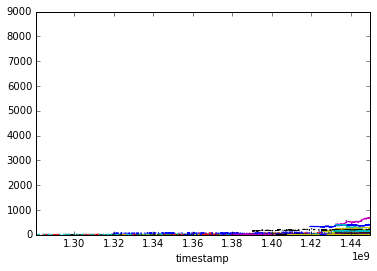

In [23]:
# Data! Horray!
df = pd.DataFrame(data=series).T
df.plot(legend=False)

In [45]:
# Deal with missing values
df = df.interpolate().fillna(method='bfill')

In [46]:
# Looks like a small number of stocks go back considerably further than the rest.  
# Conjecture is that the archive is willing to go back further because they have fewer
# data points to keep track of.  This is bad for us because it means our data frame is full
# of NAs.  Let's take the p50 starting point as our starting point and cut off anything before
# that.  

# Quick hack
df = df[df.index > 1433000000]

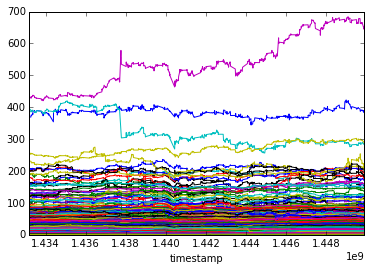

In [47]:
df.plot(legend=False)

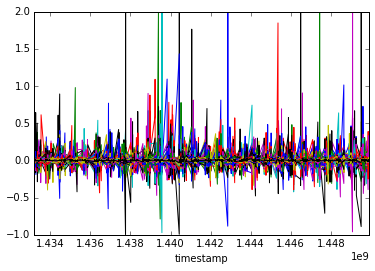

In [48]:
dif_df = df.pct_change().clip(-2, 2).fillna(0.)
dif_df.plot(legend=False)

In [33]:
# X[0] is now NAs because we diffed
X = dif_df.values
X

array([[  0.00000000e+00,   0.00000000e+00,   0.00000000e+00, ...,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,  -3.77180575e-03,   2.62474081e-05, ...,
         -1.97044335e-02,   0.00000000e+00,   7.72698004e-03],
       [  0.00000000e+00,  -1.18315192e-03,  -1.99475066e-03, ...,
         -2.01005025e-02,   0.00000000e+00,   1.78913738e-03],
       ..., 
       [  6.45380435e-03,  -6.52680653e-03,   4.21229992e-04, ...,
         -8.31600832e-03,   2.25988701e-02,  -5.21920668e-03],
       [  3.71245359e-03,   1.64242140e-03,   0.00000000e+00, ...,
          6.28930818e-03,   0.00000000e+00,   1.19359916e-02],
       [  3.02622730e-03,  -5.62192551e-03,  -2.52631579e-02, ...,
          1.14583333e-02,   3.86740331e-02,  -9.20285159e-03]])

In [34]:
pca = PCA(n_components=5)
pca.fit(X)

PCA(copy=True, n_components=5, whiten=False)

In [44]:
component = 0

idx = np.argsort(pca.components_[component])[:20]
# This is biotech. Also amazon.  We're currently measuring absolute change though, not
# relative change
print df.columns[idx]
print np.sort(pca.components_[component])[:20]

Index([u'agfsw', u'adxs', u'adxsw', u'bzun', u'cldx', u'espr', u'cybr',
       u'afmd', u'csiq', u'akba', u'exxi', u'anth', u'agen', u'exel', u'cemp',
       u'dsky', u'epzm', u'egrx', u'drwiw', u'drna'],
      dtype='object')
[-0.26699448 -0.0996109  -0.09502066 -0.08468752 -0.08016962 -0.07972951
 -0.07919586 -0.07902305 -0.07879852 -0.07718406 -0.07670548 -0.07511576
 -0.07473222 -0.07458959 -0.07385519 -0.07301774 -0.07217679 -0.07206607
 -0.07187558 -0.07129907]


In [40]:
component = 1

idx = np.argsort(pca.components_[component])[:10]
# This is biotech. Also amazon.  We're currently measuring absolute change though, not
# relative change
print df.columns[idx]
print np.sort(pca.components_[component])[:10]

Index([u'drwiw', u'axpw', u'essx', u'cbio', u'cpah', u'dxm', u'amda', u'aumaw',
       u'cercz', u'aeti'],
      dtype='object')
[-0.92837917 -0.13142286 -0.131138   -0.11692787 -0.06767789 -0.06074906
 -0.05746841 -0.05585583 -0.05320508 -0.04973345]


In [41]:
component = 2

idx = np.argsort(pca.components_[component])[:10]
# This is biotech. Also amazon.  We're currently measuring absolute change though, not
# relative change
print df.columns[idx]
print np.sort(pca.components_[component])[:10]

Index([u'cbio', u'capnw', u'bntcw', u'asti', u'abeow', u'dwch', u'cfrxw',
       u'aezs', u'anth', u'cnet'],
      dtype='object')
[-0.55068461 -0.10724781 -0.10456112 -0.09801274 -0.0937792  -0.0753229
 -0.06938222 -0.06510786 -0.05856951 -0.05192708]


In [43]:
component = 3

idx = np.argsort(pca.components_[component])[:10]
# This is biotech. Also amazon.  We're currently measuring absolute change though, not
# relative change
print df.columns[idx]
print np.sort(pca.components_[component])[:10]

Index([u'capnw', u'essx', u'deltw', u'agfsw', u'chekw', u'axpww', u'coyn',
       u'cdrb', u'bntcw', u'abgb'],
      dtype='object')
[-0.86932152 -0.20709784 -0.16079645 -0.07629636 -0.07602128 -0.06643965
 -0.06235624 -0.04970797 -0.04319772 -0.03761133]


In [36]:
idx2 = np.argsort(pca.components_[1])[:10]
df.columns[idx2]

Index([u'drwiw', u'axpw', u'essx', u'cbio', u'cpah', u'dxm', u'amda', u'aumaw',
       u'cercz', u'aeti'],
      dtype='object')

In [ ]:
idx3 = np.argsort(pca.components_[3])[:10]
df.columns[idx3]

In [ ]:
# For nasdaq stocks the following always seems to have a text description
# of the company.  
# http://www.nasdaq.com/symbol/espr
# Perform tfidf analylsis on ALL company descriptions.  Then we can take the mean 
# for the top and bottom companies in each component.
# Get all the ticker symbols from nasdaq dir, do scraping, 

In [138]:
ticker = "axpw"
s = r.get("http://www.nasdaq.com/symbol/{}".format(ticker)).content
regex = "<h2>Company Description (as filed with the SEC)</h2>"
i = s.index(regex)
s[i+70:i+1000]

'The primary business of Axion Power International, Inc. (the "Company", Axion,\n"we", "our", or "us") is to develop, design, manufacture and sell advanced\nenergy storage devices, components and systems that are based on our patented\nPbC\xc2\xae technology. We also manufacture standard and specialty lead-acid batteries.\nOur PbC batteries and battery components, which are manufactured primarily\nthrough the use of activated carbon as an alternative to lead in the battery\'s\nnegative electrode, have application to varied energy system storage functions.\n\n \n\nThe Energy Storage Industry\n\n \n\nThe energy storage industry has traditionally been based on battery, flywheel,\ncapacitor, thermal, chemical systems, power to gas, gravity, pumped storage\nhydroelectricity, and compressed air systems, to provide a temporary or back-up\nsource for energy.&nbsp;&nbsp;... <a href="http://secfilings.nasdaq.com/edgar_conv_html%2f2014%2f03%2f31%2f0001'

In [159]:
def get_nasdaq_desc(ticker):
    '''
    Given a ticker of a nasdaq stock fetches a company description
    '''
    try:
        # Sometimes it's meaninful and sometimes it's just legalease.  
        s = r.get("http://www.nasdaq.com/symbol/{}".format(ticker)).content
        regex = "<h2>Company Description (as filed with the SEC)</h2>"
        i = s.index(regex)
        return s[i+70:i+1000].replace('\n', ' ')
    except Exception:
        return None

In [162]:
get_nasdaq_desc("drwiw")

'    DragonWave Inc. was incorporated on February 24, 2000 by Certificate and Articles of Incorporation issued under the Canada Business Corporations Act (the "CBCA"). DragonWave\'s last financial year ended on February 28, 2015. The head office of DragonWave is located at 411 Legget Drive, Suite 600, Ottawa, Ontario, Canada K2K 3C9.  Business Description      Founded in 2000, we are a leading provider of high-capacity wireless Ethernet equipment used in emerging internet protocol ("IP") networks. We design, develop, market and sell proprietary, carrier-grade microwave radio frequency networking equipment (often referred to as links), that wirelessly transmit broadband voice, video and other data between two points. Our wireless carrier-Ethernet links, which are based on a native Ethernet platform, function as a wireless extension to an existing fiber and global optic core telecommunications network.&nbsp;&nbsp;... <a '

In [143]:
def get_nasdaq_tickers():
    d = "/Users/Brian/Data/gdelt/raw/data/hourly/us/nasdaq stocks"
    g = os.walk(d)
    symbols = []

    for triple in g:
        for filename in triple[2]:
            try:
                symbol = filename.split('.')[0]
                symbols.append(symbol)
            except Exception:
                # It seems that this is rare.  Not part of MVP if important at all.
                # fuck it
                pass
    return symbols

In [145]:
tickers = get_nasdaq_tickers()

In [154]:
with 

3016

In [156]:
descriptions = {}
for t in tickers[:50]:
    descriptions[t] = get_nasdaq_desc(t)
    time.sleep(0.5)

In [158]:
descriptions

{'aaap': 'We are an innovative radiopharmaceutical company that develops, produces and\ncommercializes MNM products. MNM is a medical specialty that uses trace amounts\nof radioactive compounds to treat diseases such as cancer and create functional\nimages of organs and lesions. Our lead therapeutic product candidate, Lutathera,\nis a novel MNM compound that we are currently developing for the treatment of\nNETs, a significant unmet medical need. Lutathera is a Lu-177 labeled\nsomatostatin analogue peptide that has received orphan drug designation from the\nEMA and FDA. Lutathera was also granted Fast-Track designation by the FDA in\nApril 2015 for the treatment of inoperable progressive midgut NETs. The FDA\nprovides Fast-Track designation to product candidates that treat serious\nconditions and fill an unmet medical need in order to facilitate their\ndevelopment and expedite their review.&nbsp;&nbsp;... <a href="http://secfilings.nasda',
 'aal': "American Airlines Group Inc. (AAG), a